In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tensorly.decomposition import robust_pca

In [2]:
faces = loadmat('allFaces.mat')
faces["faces"].shape

(32256, 2410)

In [3]:
D = faces["faces"][:,:64]*1.0
low,sparse = robust_pca(D,reg_E=.007, n_iter_max=150)

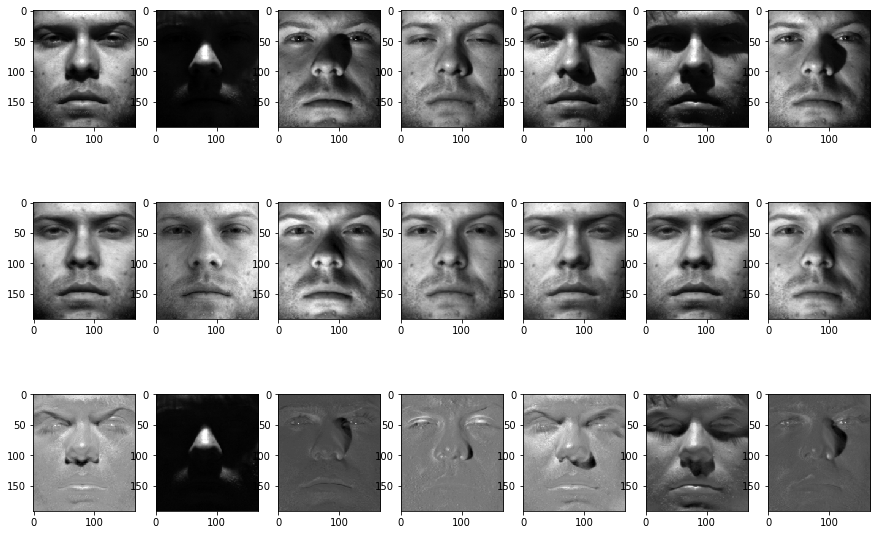

In [4]:
fig, axs = plt.subplots(3, 7, figsize=(15,10))
for i,v in enumerate([3,4,14,15,17,18,19]):
    axs[0][i].imshow(D[:,v-1].reshape((32256,1)).reshape((168,192)).T,  cmap="gray")
    axs[1][i].imshow(low[:,v-1].reshape((32256,1)).reshape((168,192)).T, cmap="gray")
    axs[2][i].imshow(sparse[:,v-1].reshape((32256,1)).reshape((168,192)).T,  cmap="gray")

In [5]:
# Reference: https://github.gatech.edu/jtay6/IYSE8803-Examples-Py/blob/master/Module%207/Examples7.py
D = faces["faces"][:,:64]*1.0
lam = 1e-2
m, n = D.shape
tol = 1e-7
maxIter = 1000

# % Initialize A,E,Y,u
Y = D.copy()
norm2 = np.linalg.norm(Y, 2)
normInf = Y.max()/lam
# Y is Lagrangian multiplier for each pixel constaint that the
# reconstructed values must match truth
Y = Y/normInf

A_hat = np.zeros((m, n))  # Smooth component, L "low rank"
E_hat = np.zeros_like(A_hat)  # Noise component, S "sparse"
# Tune these
mu = 1.25/norm2
mu_bar = mu*1e7
rho = 1.5
d_norm = np.linalg.norm(D, 'fro')
iter = 0
total_svd = 0
converged = False
stopCriterion = 1
# D is M the original data.
while not converged:
    iter += 1
    X = D - A_hat + Y/mu
    # temp_T = D-A_hat+ Y/mu
    # Soft threshold on scalars (this implementation matches slides better)
    E_hat = np.sign(X)*np.maximum(np.abs(X)-lam/mu, 0)
    # Equivalent, as per MATLAB code
    # E_hat = np.maximum(X-lam/mu,0)
    # E_hat = E_hat+np.minimum(X+lam/mu,0)
    # Soft threshold SVD
    u, s, vh = np.linalg.svd(D-E_hat+Y/mu,full_matrices=False)
    svp = (s > 1/mu).sum()
    A_hat = (u[:, :svp]*(s[:svp]-1/mu))@vh[:svp]  # reconstruct
    total_svd += 1
    Z = D-A_hat-E_hat  # Constraint violation
    Y = Y + mu*Z  # update lagragian multipliers
    mu = min(mu*rho, mu_bar)  # mu is augmented penalty coefficient
    # % stop Criterion
    stopCriterion = np.linalg.norm(Z, 'fro') / d_norm
    if stopCriterion < tol:
        converged = True

In [6]:
low = A_hat
sparse = E_hat

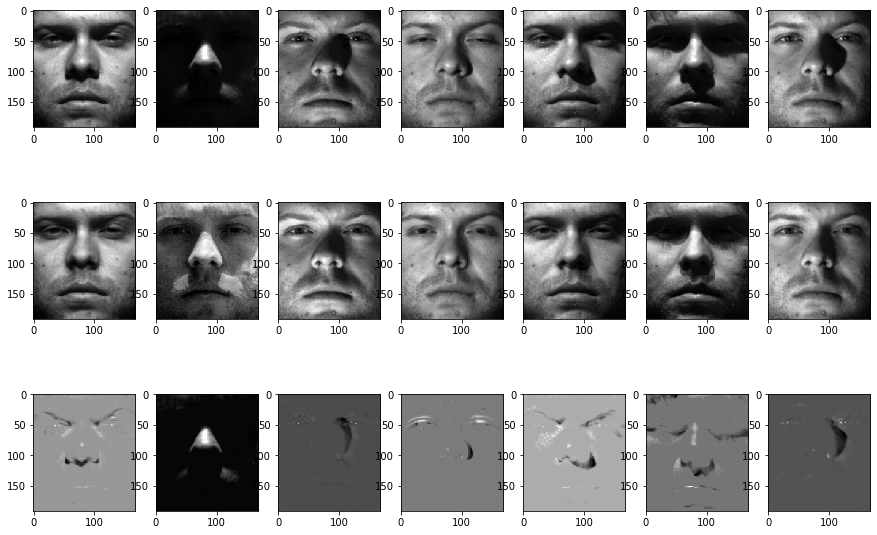

In [7]:
fig, axs = plt.subplots(3, 7, figsize=(15,10))
for i,v in enumerate([3,4,14,15,17,18,19]):
    axs[0][i].imshow(D[:,v-1].reshape((32256,1)).reshape((168,192)).T,  cmap="gray")
    axs[1][i].imshow(low[:,v-1].reshape((32256,1)).reshape((168,192)).T, cmap="gray")
    axs[2][i].imshow(sparse[:,v-1].reshape((32256,1)).reshape((168,192)).T,  cmap="gray")